In [1]:
import matplotlib
import numpy as np
import pandas as pd
from numerapi import NumerAPI
import random
import sklearn
import lightgbm
import matplotlib.pyplot as plt
# from utils import save_model, load_model, neutralize, get_biggest_change_features, validation_metrics
%matplotlib inline

from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

#pandas.options.display.max_rows=1000
#pandas.options.display.max_columns=300

In [2]:
napi = NumerAPI()

current_round = napi.get_current_round()

# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week
napi.download_dataset("v4.1/train_int8.parquet", "../data/v4.1/train_int8.parquet")
df = pd.read_parquet('../data/v4.1/train_int8.parquet')

df.head()

2023-03-30 17:16:37,028 INFO numerapi.utils: target file already exists
2023-03-30 17:16:37,030 INFO numerapi.utils: download complete


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,4,2,4,4,0,0,4,4,...,0.50,0.25,0.25,0.00,0.333333,0.000000,0.500000,0.500000,0.166667,0.000000
n003bee128c2fcfc,0001,train,2,4,1,3,0,3,2,3,...,0.75,1.00,1.00,1.00,0.666667,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,2,1,3,0,3,0,3,3,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.333333,0.500000,0.500000,0.333333
n00691bec80d3e02,0001,train,4,2,2,3,0,4,1,4,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,4,3,4,4,0,0,4,2,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000


In [3]:
# There are 2420521 rows grouped into 574 weekly eras
df.shape

(2420521, 1617)

In [4]:
# There's 1191 features with fun names generated by a hashing function
features = [c for c in df if c.startswith("feature")]
df["erano"] = df.era.astype(int)
eras = df.erano
target = "target"
print(len(features))
print(features[:5])

1586
['feature_honoured_observational_balaamite', 'feature_polaroid_vadose_quinze', 'feature_untidy_withdrawn_bargeman', 'feature_genuine_kyphotic_trehala', 'feature_unenthralled_sportful_schoolhouse']


# There are 20 targets!

## There are 10 different types of targets constructed and 2 versions of each constructed with a 20 day window or a 60 day window
## You are only scored on 'target' which currently corresponds to 'target_nomi_20' but could change in the future
## The other  auxillary targets can be very useful for training good models. Indeed you may find that a model trained on some of the auxillary targets generalize out-of-sample to 'target' better than a model trained on 'target'

In [ ]:
target = "target"
targets = [c for c in df if c.startswith("target")]
print(df.erano)
print(len(targets))

id
n003bba8a98662e4      1
n003bee128c2fcfc      1
n0048ac83aff7194      1
n00691bec80d3e02      1
n00b8720a2fdc4f2      1
                   ... 
nffcc1dbdf2212e6    574
nffd71b7f6a128df    574
nffde3b371d67394    574
nfff1a1111b35e84    574
nfff2bd38e397265    574
Name: erano, Length: 2420521, dtype: int64
29


In [ ]:
# The targets have a wide range of correlations with each other from ~0.3 to ~0.9
# This should allow the construction of many diverse models which ensemble nicely
df[targets].corr()

,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,target_waldo_v4_20,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
target,1.000000,1.000000,0.500773,0.743445,0.421980,0.944873,0.497212,0.866302,0.471679,0.822285,...,0.782010,0.429850,0.723801,0.401362,0.863873,0.479346,0.716456,0.398748,0.881409,0.486783
target_nomi_v4_20,1.000000,1.000000,0.500773,0.743445,0.421980,0.944873,0.497212,0.866302,0.471679,0.822285,...,0.782010,0.429850,0.723801,0.401362,0.863873,0.479346,0.716456,0.398748,0.881409,0.486783
target_nomi_v4_60,0.500773,0.500773,1.000000,0.420377,0.742888,0.495029,0.954337,0.470585,0.866328,0.454590,...,0.436680,0.767359,0.408407,0.707522,0.482413,0.860768,0.404631,0.708969,0.490519,0.879609
target_tyler_v4_20,0.743445,0.743445,0.420377,1.000000,0.393337,0.737327,0.417217,0.709692,0.399233,0.720234,...,0.687341,0.379647,0.643454,0.356026,0.719232,0.403368,0.607384,0.336013,0.722729,0.408091
target_tyler_v4_60,0.421980,0.421980,0.742888,0.393337,1.000000,0.416991,0.738557,0.399665,0.708798,0.404190,...,0.387036,0.677148,0.363369,0.631416,0.406777,0.717176,0.340995,0.601476,0.411729,0.720453
target_victor_v4_20,0.944873,0.944873,0.495029,0.737327,0.416991,1.000000,0.498801,0.864092,0.469942,0.820644,...,0.780026,0.427489,0.717996,0.397050,0.862220,0.476881,0.731516,0.406433,0.872040,0.481624
target_victor_v4_60,0.497212,0.497212,0.954337,0.417217,0.738557,0.498801,1.000000,0.470375,0.866269,0.454263,...,0.436151,0.766819,0.405861,0.703632,0.481953,0.860602,0.411099,0.720778,0.487418,0.873001
target_ralph_v4_20,0.866302,0.866302,0.470585,0.709692,0.399665,0.864092,0.470375,1.000000,0.491720,0.866905,...,0.787824,0.431726,0.694034,0.383799,0.860645,0.476482,0.716941,0.399110,0.827829,0.459359
target_ralph_v4_60,0.471679,0.471679,0.866328,0.399233,0.708798,0.469942,0.866269,0.491720,1.000000,0.469920,...,0.438792,0.772580,0.391219,0.677991,0.479716,0.857644,0.405035,0.709887,0.463914,0.825606
target_waldo_v4_20,0.822285,0.822285,0.454590,0.720234,0.404190,0.820644,0.454263,0.866905,0.469920,1.000000,...,0.818309,0.442804,0.719982,0.394316,0.822856,0.459904,0.687460,0.383646,0.791267,0.441579


# 1191 features, no feature groups!

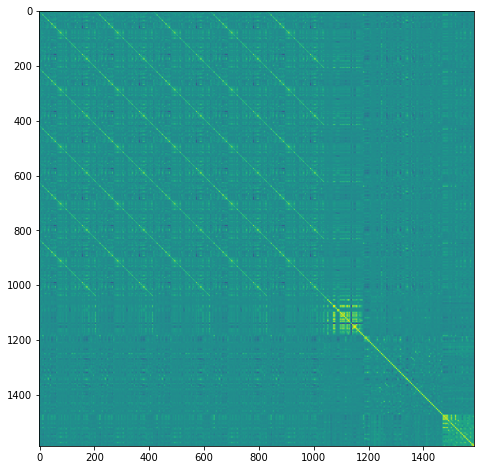

In [ ]:
# The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# visualize the feature correlation matrix. Feel free to construct your own groupings!
plt.figure(figsize = (8,8))
plt.imshow(df[df.erano==574][features].corr())

In [ ]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [ ]:
# There are 574 eras numbered from 1 to 574
eras.describe()

count    2.420521e+06
mean     3.042725e+02
std      1.598538e+02
min      1.000000e+00
25%      1.720000e+02
50%      3.040000e+02
75%      4.430000e+02
max      5.740000e+02
Name: erano, dtype: float64

<AxesSubplot: xlabel='erano'>

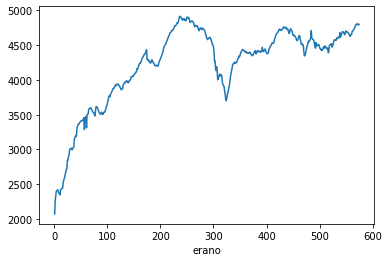

In [ ]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
df.groupby(eras).size().plot()

In [ ]:
# The target is discrete and takes on 5 different values with about 5% in 0 & 1, 20% in 0.75 & 0.25, and 50% in 0.50
df.groupby(target).size()/len(df)

target
0.00    0.050007
0.25    0.200001
0.50    0.499975
0.75    0.200014
1.00    0.050003
dtype: float64

In [ ]:
# Some new targets have a different distribution and the bins are less rigid in the percent of samples contained
print(df.groupby('target_william_v4_20').size()/len(df))
print()
print(df.groupby('target_thomas_v4_20').size()/len(df))

target_william_v4_20
0.000000    0.023195
0.166667    0.059765
0.333333    0.218543
0.500000    0.387231
0.666667    0.209928
0.833333    0.064677
1.000000    0.032295
dtype: float64

target_thomas_v4_20
0.000000    0.017651
0.166667    0.051188
0.333333    0.203729
0.500000    0.464680
0.666667    0.183714
0.833333    0.052028
1.000000    0.023394
dtype: float64


# Some of the features are very correlated
Some even perfectly correlated within a particular era

In [ ]:
feature_corrs = df[df.erano==574][features].corr()  # df.shape, [p x p], p - features

In [ ]:
feature_corrs.stack().head() # df.shape => [p^2 x 1], index is a tuple (feature1, feature2)

feature_honoured_observational_balaamite  feature_honoured_observational_balaamite     1.000000
                                          feature_polaroid_vadose_quinze               0.023532
                                          feature_untidy_withdrawn_bargeman            0.150666
                                          feature_genuine_kyphotic_trehala             0.257497
                                          feature_unenthralled_sportful_schoolhouse   -0.191795
dtype: float64

In [50]:
def plot_bar_df(df, columns):
    return (
        df.iloc[np.r_[0:5, -5:0]]
        .style
        .bar(subset=columns, align="mid", color=["#d65f5f", "#5fba7d"])
    )

In [52]:
tdf = feature_corrs.stack()
# Remove correlation of a feature with itself and remove duplicates (corr(A,B) = corr(B,A)).
# `corr1.index.get_level_values(0) < corr1.index.get_level_values(1)` checks if a
# feature name on the left is less than on the right.
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
plot_bar_df(
    df=(
        tdf
        .sort_values()
        .to_frame()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "corr"})
    ),
    columns=["corr"],
)

,feature_1,feature_2,corr
0,feature_optic_mycelial_whimper,feature_productile_auriform_fil,-0.965431
1,feature_careworn_motivational_requisite,feature_loftier_sightly_lyric,-0.959288
2,feature_applausive_forgettable_mishanter,feature_marled_coliform_proctorship,-0.958351
3,feature_sodding_choosy_eruption,feature_utmost_excitable_emir,-0.957101
4,feature_dissident_templed_shippon,feature_rose_buttoned_dandy,-0.956268
1256900,feature_encysted_conventionalized_dematerialization,feature_wetter_unbaffled_loma,0.988130
1256901,feature_ecstatic_foundational_crinoidea,feature_indusiate_canned_cosh,0.988130
1256902,feature_faint_consociate_rhytidectomy,feature_mercian_luddite_aganippe,0.989067
1256903,feature_liftable_direful_polyploid,feature_objective_micro_langton,0.990317
1256904,feature_dustproof_unafraid_stampede,feature_neutered_postpositive_writ,0.991358


### The correlation can change over time
You can see this by comparing feature correlations on the first half and second half on the training set

In [ ]:
print(f"{eras.median()=}")

eras.median()=304.0


In [ ]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [ ]:
corr1 = df1[df1.erano==1][features].corr()  # df.shape, [p x p], p - features
corr1 = corr1.unstack() # df.shape => [p^2 x 1], index is a tuple (feature1, feature2)
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [ ]:
corr2 = df2[df2.erano==574][features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [53]:
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
(
    tdf
    .iloc[np.r_[0:5, -5:0]]
    .style
    .bar(subset=["corr_diff"], align="mid", color=["#d65f5f", "#5fba7d"])
)
plot_bar_df(df=tdf, columns=["corr_diff"])

## Some features are predictive on their own

In [42]:
# First row is the target, the rest are the features
X_lastera = df[df.erano==574][[target]+features].values.astype(float).T 
feature_scores = {feature: score for feature, score in zip(features, np.corrcoef(X_lastera)[1:,0])}

In [56]:
plot_bar_df(pd.Series(feature_scores).sort_values().to_frame().rename(columns={0: "corr_w_target"}), columns=["corr_w_target"])

,corr_w_target
feature_primogenital_paralytic_minx,-0.055771
feature_photic_untunable_father,-0.053633
feature_falsifiable_performative_maxixe,-0.053468
feature_uninvested_unwishful_scoria,-0.052810
feature_illuvial_algebraic_modem,-0.051494
feature_sixteenth_foliate_ovary,0.052646
feature_revelational_natty_nephralgia,0.053139
feature_undreamt_crescive_alternator,0.053633
feature_steadier_untrenched_bernstein,0.055114
feature_uninforming_predictable_pepino,0.055936


<AxesSubplot: >

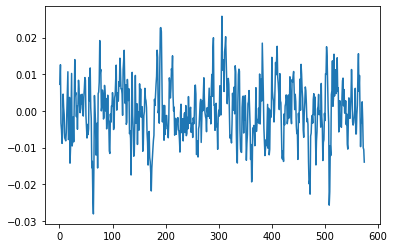

In [58]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target].astype(float), tdf["feature_untidy_withdrawn_bargeman"].astype(float))[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

<AxesSubplot: >

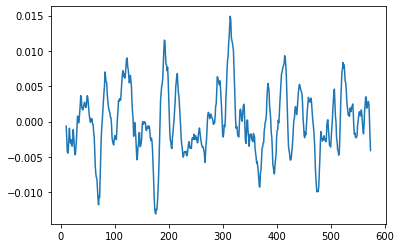

In [59]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

## The feature exposures of different targets can be very different, even orthogonal

In [ ]:
feature_scores_nomi20 = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_v4_20']+features].T)[1:,0])}

In [ ]:
feature_scores_nomi60 = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_v4_60']+features].fillna(0.5).T)[1:,0])}

In [ ]:
plt.scatter(feature_scores_nomi20.values(), feature_scores_nomi60.values())
print(np.corrcoef(list(feature_scores_nomi20.values()), list(feature_scores_nomi60.values()))[0,1])

In [ ]:
feature_scores_jerome = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_jerome_v4_60']+features].fillna(0.5).T)[1:,0])}

In [ ]:
feature_scores_ben = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_ben_v4_20']+features].fillna(0.5).T)[1:,0])}

In [ ]:
plt.scatter(feature_scores_jerome.values(), feature_scores_ben.values())
print(np.corrcoef(list(feature_scores_jerome.values()), list(feature_scores_ben.values()))[0,1])

# Gotcha: MSE looks worse than correlation out of sample
Models will generally be overconfident, so even if they are good at ranking rows, the Mean-Squared-Error of the residuals could be larger than even the Mean-Squared-Error of the target (r-squared<0)

In [ ]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [66]:
# Columns with null values in df
null_cols = df.columns[df.isnull().any()]
not_null_cols = set(df.columns) - set(null_cols)
not_null_feats = [col for col in df.columns if col in not_null_cols and col in features]
print(f"{len(not_null_feats)=}")

len(not_null_feats)=1206


In [67]:
linear1 = linear_model.LinearRegression()
linear1.fit(df1[not_null_feats], df1[target])
linear2 = linear_model.LinearRegression()
linear2.fit(df2[not_null_feats], df2[target])

In [ ]:
# Note in particular that the R-squared of (train_on_1, eval_on_2) is slightly negative!
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

In [ ]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

In [ ]:
# This can be be run with LightGBM as well

In [ ]:
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[features], df1[target])
lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df2[features], df2[target])

In [ ]:
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

In [ ]:
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

# Gotcha: Eras are now overlapping!

Eras are weekly (5 days), but the target is four weeks out (20 days). You can subsample the eras (every 4th era) to prevent models from overfitting due to overlapping eras. You can then ensemble the models trained on each of the 4 different ways to subsample.

In [ ]:
# train model on all eras in df1
lgb_all = lightgbm.LGBMRegressor()
lgb_all.fit(df1[features], df1[target])

In [ ]:
lgb_all.feature_name_

In [ ]:
# train models on subsamples eras in df1
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])

lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])

lgb3 = lightgbm.LGBMRegressor()
lgb3.fit(df1[eras.isin(np.arange(3, 304, 4))][features], df1[eras.isin(np.arange(3, 304, 4))][target])

lgb4 = lightgbm.LGBMRegressor()
lgb4.fit(df1[eras.isin(np.arange(4, 304, 4))][features], df1[eras.isin(np.arange(4, 304, 4))][target])

In [ ]:
# calculate predictions for each model
preds = [
        pd.Series(model.predict(df2[features]), index=df2.index)
    for model in [lgb_all, lgb1, lgb2, lgb3, lgb4]
]

In [ ]:
# numerai score of model trained on all eras of df1
numerai_score(df2[target], preds[0])

In [ ]:
# numerai score of ensemble of models trained on all subsampled eras of df1
numerai_score(df2[target], pd.concat(preds, axis=1)[[1,2,3,4]].mean(axis=1))

# Gotcha: eras are homogenous, but different from each other
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of ~5.1%, but a time series split reports a lower score of ~2.6%

# Gotcha: Eras are now overlapping!
##  Even era-wise cross-validation will now have leakage!
Eras are weekly (5 days), but the target is four weeks out (20 days). You can either use blocks of eras and purge the overlapping sections or subsample the eras (every 4th era) to make them not overlapping and prevent leakage

In [5]:
# Subsample data to every 4th era to prevent overlapping eras
df = df[eras.isin(np.arange(1, 575, 4))]
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]
eras = eras[eras.isin(np.arange(1, 575, 4))]

/var/folders/yb/bysg0gmj6sdb_006hzx07fjc0000gn/T/ipykernel_83120/729810413.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[eras<=eras.median()]
/var/folders/yb/bysg0gmj6sdb_006hzx07fjc0000gn/T/ipykernel_83120/729810413.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[eras>eras.median()]


In [ ]:
# Because the TimeSeriesSplit class in sklearn does not use groups and won't respect era boundries, we implement
# a version that will

from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples

class TimeSeriesSplitGroups(_BaseKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits, shuffle=False, random_state=None)

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_list = np.unique(groups)
        n_groups = len(group_list)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_groups))
        indices = np.arange(n_samples)
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        test_starts = list(test_starts)[::-1]
        for test_start in test_starts:
            
            yield (indices[groups.isin(group_list[:test_start])],
                   indices[groups.isin(group_list[test_start:test_start + test_size])])


In [ ]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    TimeSeriesSplitGroups(5)
]

In [ ]:
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [ ]:
for cv in crossvalidators:
    print(cv)
    print(np.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

# Gotcha:  {0, 1} are noticeably different from {0.25, 0.75}
This makes training a classifier one-versus-rest behave counterintuitively.

Specifically, a multinomial classifier seem to learn how to pick out extreme targets, and their predictions are the most correlated

In [ ]:
# Train a standard logistic regression as a classifier
logistic = linear_model.LogisticRegression(multi_class='multinomial', solver='saga')
logistic.fit(df1[features], (df1[target]*4).astype(int))
logistic.score(df1[features], (df1[target]*4).astype(int))

In [ ]:
# The first and last class are highly correlated
corrs=np.corrcoef(logistic.predict_proba(df2[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

In [ ]:
# Out-of-sample correlation is 3.5%
preds = pd.Series(logistic.predict_proba(df2[features]).dot(logistic.classes_), index=df2.index)
numerai_score(df2[target], preds)

In [ ]:
# A standard linear model has a slightly lower correlation out-of-sample
linear = linear_model.LinearRegression()
linear.fit(df1[features], df1[target])
linear.score(df2[features], df2[target])
preds = pd.Series(linear.predict(df2[features]), index=df2.index)
numerai_score(df2[target], preds)

## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 15, training on each block, and evaluating on each other block.

In [ ]:
# convert the subsampled era labels to continuous integers
eras_sub = (eras-1)//4

In [ ]:
eras15 = (eras_sub // 15) * 15
eras15.value_counts()

In [ ]:
results15 = []
for train_era, tdf in df.groupby(eras15):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df.groupby(eras15):
        results15.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

In [ ]:
results_df = pd.DataFrame(
    results15,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

In [ ]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the early groups that does not seem to be relevant to other eras, and the
# overall performance seems to decrease a bit over time.
plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

## Gotcha: Since the signal-to-noise ratio is so low, models can take many more iterations than expected, and have scarily high in-sample performance

In [ ]:
def our_score(preds, dtrain):
    return "score", -np.corrcoef(preds, dtrain.get_label())[0,1], False

df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [ ]:
dtrain = lightgbm.Dataset(df1[features], df1[target])
dtest = lightgbm.Dataset(df2[features], df2[target])
dall = lightgbm.Dataset(df[features], df[target])

In [ ]:
param = {
    'max_depth':3,
    'eta':0.1,
    'objective':'regression',
    'metric':'mse',
    'nthread': -1,
}
evals_result = {}
bst = lightgbm.train(
    params=param,
    train_set=dtrain,
    feval=our_score,
    num_boost_round=500,
    valid_sets=[dtrain, dtest],
    valid_names=['train', 'test'],
    evals_result=evals_result,
    verbose_eval=20,
)

(-pd.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot(ylim=[0,0.25])

# The results are sensitive to the choice of parameters, which should be picked through cross-validation

In [8]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [ ]:
models = [
    linear_model.LinearRegression(),
] + [
    linear_model.ElasticNet(alpha=alpha)
    for alpha in [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001]
] + [
    lightgbm.LGBMRegressor(n_jobs=-1),
    lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000, max_depth=5),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.001, n_estimators=10000, max_depth=5),
]

In [ ]:
for model in models:
    print(" -- ", model)   
    model.fit(df1[features], df1[target])
    outsample = numerai_score(df2[target], pd.Series(model.predict(df2[features]), index=df2.index))
    insample = numerai_score(df1[target], pd.Series(model.predict(df1[features]), index=df1.index))
    print(
        f"outsample: {outsample}, insample: {insample}"
    )
    print()

## Gotcha: Models with large exposures to individual features tend to perform poorly or inconsistently out of sample ## 


In [5]:
import numpy as np
import scipy.stats
import gc

In [17]:
# Subsample data to every 4th era to prevent overlapping eras
df = df[eras.isin(np.arange(1, 575, 128))]
df = df.infer_objects()
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]
eras = eras[eras.isin(np.arange(1, 575, 128))]
eras = eras[eras.isin(np.arange(1, 575, 128))]
gc.collect()
df1.shape

(10790, 1618)

In [7]:
# Train a standard xgboost on half the train eras
lgb = lightgbm.LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01, n_jobs=-1)
lgb.fit(df1[features].astype(np.float32), df1[target].astype(np.float32))
lgb_preds = lgb.predict(df2[features].astype(np.float32))

### Our predictions have correlation < -0.4 and > 0.20 for some single features!
Sure hope those features continue to act as they have in the past!

In [8]:
corr_list = []
for feature in features:
    corr_list.append(np.corrcoef(df2[feature].astype(float), lgb_preds)[0,1])
corr_series = pd.Series(corr_list, index=features)
corr_series.describe()

count    1586.000000
mean        0.009322
std         0.045233
min        -0.135964
25%        -0.020689
50%         0.010335
75%         0.037769
max         0.183820
dtype: float64

In [14]:
from sklearn.preprocessing import MinMaxScaler
import scipy

def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, end="\r")
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values.astype(float)
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values.astype(float)
        scores -= proportion * exposures @ np.linalg.pinv(exposures) @ scores
        scores /= scores.std(ddof=0)
        computed.append(scores)
    return pd.DataFrame(np.concatenate(computed), columns=columns, index=df.index)

In [19]:
df2["preds"] = lgb_preds
# make tgt_feat_cols columns in df as np.float32
df2 = df2.infer_objects()
df2["preds_neutralized"] = neutralize(df2, 
                                      columns=["preds"], 
                                      neutralizers=features, 
                                      proportion=0.5, # neutralize by 50% within each era
                                      normalize=True,
                                      era_col='era') 

scaler = MinMaxScaler()
df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1

/var/folders/yb/bysg0gmj6sdb_006hzx07fjc0000gn/T/ipykernel_84049/381184919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds


### Now our single feature exposures are much smaller

In [21]:
corr_list2 = []
for feature in features:
    corr_list2.append(np.corrcoef(df2[feature].astype(float), df2["preds_neutralized"].astype(float))[0,1])
corr_series2 = pd.Series(corr_list2, index=features)

In [22]:
corr_series2.describe()

count    1586.000000
mean        0.007753
std         0.029973
min        -0.086486
25%        -0.011587
50%         0.008073
75%         0.026516
max         0.122735
dtype: float64

In [32]:
era_col = "era"
unique_eras = df2[era_col].unique()
neutralizers = features
normalize = True
columns = ["preds"]
computed = []
proportion = 0.5

In [33]:
u = unique_eras[0]
print(u)

0385


In [34]:
df_era = df2[df2[era_col] == u]
scores = df_era[columns].values.astype(float)

(array([1.300e+01, 6.900e+01, 4.590e+02, 1.470e+03, 1.661e+03, 5.990e+02,
        1.190e+02, 1.900e+01, 4.000e+00, 1.000e+00]),
 array([0.33139007, 0.37238038, 0.41337069, 0.45436101, 0.49535132,
        0.53634164, 0.57733195, 0.61832226, 0.65931258, 0.70030289,
        0.74129321]),
 <BarContainer object of 10 artists>)

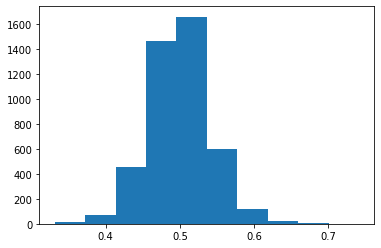

In [52]:
x = scores.T[0]
plt.hist(x)

In [ ]:
exposures = df_era[neutralizers].values.astype(float)
scores -= proportion * exposures @ np.linalg.pinv(exposures) @ scores
scores /= scores.std(ddof=0)
computed.append(scores)

### Our overall score goes down, but the scores are more consistent than before. This leads to a higher sharpe

In [24]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.00022235880087093964
score for balanced feature expo: 0.0032372034643258947
std for high feature exposure: 0.020299406067780988
std for balanced feature expo: 0.004956026674713385
sharpe for high feature exposure: 0.010953955998932662
sharpe for balanced feature expo: 0.6531852382560285


In [25]:
balanced_scores_per_era.describe()

count    2.000000
mean     0.003237
std      0.007009
min     -0.001719
25%      0.000759
50%      0.003237
75%      0.005715
max      0.008193
dtype: float64

In [26]:
unbalanced_scores_per_era.describe()

count    2.000000
mean     0.000222
std      0.028708
min     -0.020077
25%     -0.009927
50%      0.000222
75%      0.010372
max      0.020522
dtype: float64

## We can also try to be more clever about what features we neutralize
### The "riskiest" features are the features the predictions are most exposed to that also have the highest volatility 

In [ ]:
# compute feature correlations with target on the first half data
all_feature_corrs = df1.groupby('era').apply(lambda d: d[features].corrwith(d[target]))
# compute the volatility of the feature correlations
feature_corr_volatility = all_feature_corrs.std()

In [ ]:
# calculate the feature exposures of the predictions
feature_exposure_list = []
for feature in features:
    feature_exposure_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
feature_exposure_list = pd.Series(feature_exposure_list, index=features)

In [ ]:
# get list of 100 riskiest features
riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()

In [ ]:
# 50% neutralize to the riskiest features
df2["preds_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=["preds"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

scaler = MinMaxScaler()
df2["preds_neutralized_riskiest_100"] = scaler.fit_transform(df2[["preds_neutralized_riskiest_100"]]) # transform back to 0-1

### The score goes down less and the sharpe goes up more than 50% neutralizing all the features

In [ ]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

### Interestingly, the maximal feature exposure magnitude is actually lower (~0.28 vs ~0.31) than when 50% neutralizing all features

In [ ]:
corr_list3 = []
for feature in features:
    corr_list3.append(np.corrcoef(df2[feature], df2["preds_neutralized_riskiest_100"])[0,1])
corr_series3 = pd.Series(corr_list3, index=features)
corr_series3.describe()

In [ ]:
corr_series3.describe()

# Training on the alternative targets can result in models with different patterns of feature exposures
## This is a great way to go after MMC and very useful for ensembling

In [ ]:
lgb = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb.fit(df1[features], df1['target'])

In [ ]:
lgb_jerome = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb_jerome.fit(df1[features], df1['target_jerome_v4_20'])

In [ ]:
# The feature importances for each model are about 60% correlated

In [ ]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(lgb.feature_importances_, alpha=.5)
plt.plot(lgb_jerome.feature_importances_, alpha=.5)
plt.subplot(1,2,2)
plt.scatter(lgb.feature_importances_, lgb_jerome.feature_importances_)

print(np.corrcoef([lgb.feature_importances_, lgb_jerome.feature_importances_])[0,1])

In [ ]:
lgb_preds = lgb.predict(df2[features])
lgb_jerome_preds = lgb_jerome.predict(df2[features])

In [ ]:
# The predictions are about 68% correlated
np.corrcoef([lgb_preds, lgb_jerome_preds])[0,1]

In [ ]:
df2["preds"] = lgb_preds
df2["preds_jerome"] = lgb_jerome_preds

In [ ]:
# 50% neutralize to riskest features for each model as above
for preds in ["preds", "preds_jerome"]:
    feature_exposure_list = []
    for feature in features:
        feature_exposure_list.append(np.corrcoef(df2[feature], df2[preds])[0,1])
    feature_exposure_list = pd.Series(feature_exposure_list, index=features)

    riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()
    
    df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=[f"{preds}"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

In [ ]:
# create ensemble
df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2

In [ ]:
scores = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
scores_jerome = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome"], d[target])[0,1])

scores_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])
scores_jerome_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome_neutralized_riskiest_100"], d[target])[0,1])

scores_ens = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_ens"], d[target])[0,1])

print(f"score for target: {scores.mean()}")
print(f"score for target_jerome: {scores_jerome.mean()}")
print()
print(f"sharpe for target: {scores.mean()/scores.std(ddof=0)}")
print(f"sharpe for target_jerome: {scores_jerome.mean()/scores_jerome.std(ddof=0)}")
print()
print(f"score for target after neutralization: {scores_derisked.mean()}")
print(f"score for target_jerome after neutralization: {scores_jerome_derisked.mean()}")
print()
print(f"sharpe for target after neutralization: {scores_derisked.mean()/scores_derisked.std(ddof=0)}")
print(f"sharpe for target_jerome after neutralization: {scores_jerome_derisked.mean()/scores_jerome_derisked.std(ddof=0)}")
print()
print(f"score for target + target_jerome ensemble: {scores_ens.mean()}")
print(f"sharpe for target + target_jerome ensemble: {scores_ens.mean()/scores_ens.std(ddof=0)}")


## We see here that the model trained on `target_jerome` actually predicts `target` slightly better than the model trained on `target` (albeit with a lower Sharpe) both before and after neutralization of the riskiest features

In [ ]:
# calculate correlation of neutralized predictions
df2[[f"preds_neutralized_riskiest_100", f"preds_jerome_neutralized_riskiest_100"]].corr()

## Given that the neutralized version trained on `target_jerome` gets slightly better average score, but is only about 63% correlated with the neutralized version trained on `target`, it is an excellent candidate for MMC
## However, ensembling the two neutralized predictions gives a model with the highest average score and a great Sharpe value